# Res Net

In [1]:
import torch, time
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose
from torchvision import transforms  
from torch.utils.data import DataLoader


import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

import torch.nn as nn
from torch import optim
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
print(device)


cuda


# Dataset


In [3]:
tf = Compose([
     transforms.ConvertImageDtype(torch.float),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
     transforms.Pad(1)
 ])

#transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

class CustomCountriesDataset(Dataset):
    def __init__(self, df, transform=tf, target_transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = read_image(self.df.iloc[idx, 0])
        label = self.df.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
df = pd.read_csv("../output_224.csv")

# train-test split
train_data, test_data = train_test_split(df, test_size=0.2)

# validation split
#train_data, val_data = train_test_split(train_data, test_size=0.2)



In [5]:
train_dataset = CustomCountriesDataset(train_data, transform=tf)
test_dataset = CustomCountriesDataset(test_data, transform=tf)
#val_dataset = CustomCountriesDataset(val_data, transform=tf)


In [6]:
bsz = 64
test_dataloader = DataLoader(test_dataset, batch_size=bsz, shuffle=False)
train_dataloader = DataLoader(train_dataset, batch_size=bsz, shuffle=True)
#val_dataloader = DataLoader(val_dataset, batch_size=bsz, shuffle=False)
#print(next(iter(train_dataloader)))
"""
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features}")
print(f"Labels batch shape: {train_labels}")
img = train_features[0].squeeze()
label = train_labels[0]
image_np = img.numpy().transpose((1, 2, 0))
plt.imshow(image_np)
plt.show()
print(f"Label: {label}")"""



'\ntrain_features, train_labels = next(iter(train_dataloader))\nprint(f"Feature batch shape: {train_features}")\nprint(f"Labels batch shape: {train_labels}")\nimg = train_features[0].squeeze()\nlabel = train_labels[0]\nimage_np = img.numpy().transpose((1, 2, 0))\nplt.imshow(image_np)\nplt.show()\nprint(f"Label: {label}")'

In [7]:
class CNN(nn.Module):
    def __init__(self,num_classes, in_channels=3):
        super(CNN, self).__init__()
        self.convolutions = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten()
        )
        self.fcl = nn.Sequential(
            nn.Linear(512 * 14 * 14, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, num_classes)
        )
    def forward(self, x):
        x = self.convolutions(x)
        x = self.fcl(x)
        return x

Validation loss: 0.0005, Validation acc: 0.9901: 100%|██████████| 103/103 [00:19<00:00,  5.16batch/s]


ValueError: x and y must have same first dimension, but have shapes (5,) and (410,)

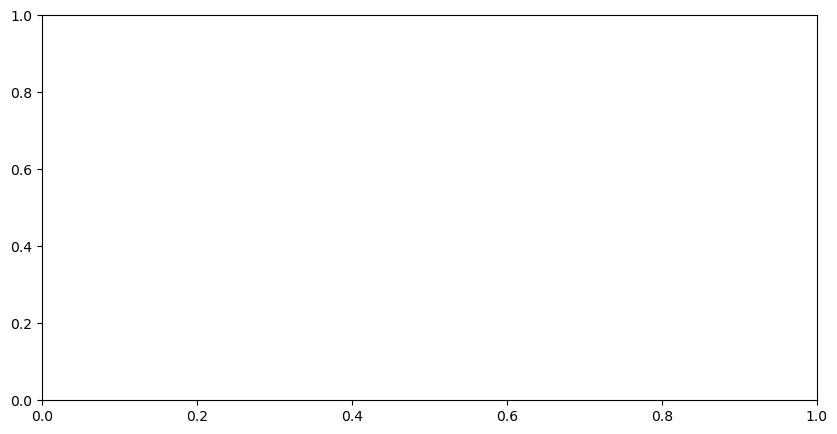

In [8]:
model = CNN(num_classes=2, in_channels=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

update_frequency = 5 # i.e., every x batches.
num_epochs = 5

train_loss_history = []
train_acc_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_train_samples = 0
    bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for i, (X_batch, y_batch) in enumerate(bar):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        # forward pass
        pred = model(X_batch)
        loss = criterion(pred, y_batch)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss calc
        running_loss += loss.item()

        # acc calc
        _, predicted = torch.max(pred, axis=1)
        correct_predictions += (predicted == y_batch).sum().item()

        total_train_samples += y_batch.shape[0]

        if i % update_frequency== 0:
            curr_train_loss = running_loss / total_train_samples
            curr_train_acc = correct_predictions / total_train_samples

            train_loss_history.append(curr_train_loss)
            train_acc_history.append(curr_train_acc)

            bar.set_description(f"Epoch {epoch+1}/{num_epochs} - Loss: {curr_train_loss:.4f} Acc: {curr_train_acc:.4f}")


    """    avg_train_loss = running_loss / len(train_dataset)
    avg_train_acc = correct_predictions / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Avg Train Loss: {avg_train_loss:.4f}, Avg Train Acc: {avg_train_acc:.4f}")"""

    # validation
    model.eval()
    running_val_loss, running_val_acc = 0.0, 0.0
    total_val_samples = 0

    with torch.no_grad():
        bar = tqdm(test_dataloader, desc="Validation", unit="batch")
        for i, (X_batch, y_batch) in enumerate(bar):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # forward pass
            val_pred = model(X_batch)

            # calculate batch loss
            running_val_loss += criterion(val_pred, y_batch).item()

            # calculate batch acc
            running_val_acc += torch.sum(torch.argmax(val_pred, axis=1) == y_batch).item()

            total_val_samples += y_batch.shape[0]
            
            if i % update_frequency == 0:
                curr_val_loss = running_val_loss / total_val_samples
                curr_val_acc = running_val_acc / total_val_samples
                bar.set_description(f"Validation loss: {curr_val_loss:.4f}, Validation acc: {curr_val_acc:.4f}")

"""    avg_val_loss = running_val_loss / len(val_dataset)
    avg_val_acc = running_val_acc / len(val_dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Avg Val Loss: {avg_val_loss:.4f}, Avg Val Acc: {avg_val_acc:.4f}")"""

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), train_acc_history, label='Training Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.grid(True)
plt.show()
print("Finished!")